# Fifth exercise (Chapter 7)¶

Chapter 7 is about regularization, in this assignment we will implement various forms of regularization for MLP's. 

* L2 regularization
* Dropout
* Early stopping

In the following code block, all necessary imports are provided as well as the data generators. You can use your MLP implementation from the previous assignment or the reference implementation attached. In this reference implementations, there are some slight differences with the network that was provided for the previous example, most notably: 

* The cost function now also has an update function integrated
* The data format is standardized for all sets (train, test and validation)

## Data

We will make use of the digits dataset, standard packed in sklearn. It contains a similar classification task as MNIST, however the images are smaller (64 pixels), making experimenting with it faster. 

For your convenience, a convert function has been provided to convert the dataset into the format that the reference network accepts. 

In [2]:
%matplotlib inline
import numpy as np
# import scipy.stats
import random
from sklearn.datasets import load_digits
from IPython.core.debugger import set_trace
import matplotlib.pyplot as plt
from scipy.stats import bernoulli

In [3]:
def vectorized_result(j):
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

X, y = load_digits(return_X_y=True)
testsize = len(X) / 10
validsize = len(X) / 10

train_indices = np.arange(len(X) - testsize - validsize, dtype=np.int)
valid_indices = np.arange(len(train_indices), len(X) - testsize, dtype=np.int)
test_indices = np.arange(len(train_indices) + len(valid_indices), len(X), dtype=np.int)

train_set = [(np.reshape(X[idx], (len(X[idx]), 1)), vectorized_result(y[idx])) for idx in train_indices]
valid_set = [(np.reshape(X[idx], (len(X[idx]), 1)), vectorized_result(y[idx])) for idx in valid_indices]
test_set  = [(np.reshape(X[idx], (len(X[idx]), 1)), vectorized_result(y[idx])) for idx in test_indices]

num_features = len(X[0])
num_classes = 10

## Reference Network

Replace the cell below with your own network from exercise 6. Make sure that it doesn't deviate to much from the reference implementation.

In [18]:
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))


def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

def Generate_DropOut_Mask(p_DropOut, sizes):   # p_DropOut is Tuple (p_input, p_hidden)
    """Create Mask for randomly switch on/off weights with same dimensions as weights: List of arrays"""
    mu = [] 
    for i, w in enumerate(weights):      # sum of squared of each single weight parameter --> iterate through layers
        mask = bernoulli.rvs(p_DropOut[i!=0], size=w.shape)  # DropOut[0] if input layer (i==0), DropOut(1) else
        mu.append(mask)   # sum of elementwise squared matrices
    return mu

class QuadraticCost(object):
    @staticmethod
    def fn(a, y, weights = []):
        """Return the cost associated with an output ``a`` and desired output
        ``y``.
        
        a is an array (size (num_classes, 1)) the activations of the output_layer,
        y is an array (same size) with the class label.
        """
        return 0.5 * np.linalg.norm(a - y) ** 2

    @staticmethod
    def delta(z, a, y):
        """Return the derivative of the cost function wrt z.
           Recall that a=sigmoid(z).
           
           z, a and y are arrays of shape (num_classes, 1)
        """
        return (a - y) * sigmoid_prime(z)

    @staticmethod
    def update(w, nw, eta, size):
        """Does a single gradient step. 
        
        w and nw are arrays with size corresponding to the weights vector; 
        eta and size are scalars. 
        """
        return w - (eta / size) * nw


class RidgeCost(object):
    
    def __init__(self, alpha=0):
        self.alpha = alpha
    
    # @staticmethod
    def fn(self, a, y, weights):

        squared_weights = 0
        for w in weights:      # sum of squared of each single weight parameter --> iterate through layers
            squared_weights += np.sum(w**2)   # sum of elementwise squared matrices

        return 0.5 * np.linalg.norm(a - y) ** 2 + (self.alpha/2) * squared_weights

    def delta(self, z, a, y):
        """Return the derivative of the cost function wrt z.
           Recall that a=sigmoid(z).
           
           z, a and y are arrays of shape (num_classes, 1)
        """
        return (a - y) * sigmoid_prime(z)  

    # @staticmethod
    def update(self, w, nw, eta, size):
        """Does a single gradient step. 
        
        w and nw are arrays with size corresponding to the weights vector; 
        eta and size are scalars. 
        """
        return (1 - eta*self.alpha) * w - (eta / size) * nw
    

class Network(object):
    def __init__(self, sizes, cost=QuadraticCost, p_DropOut=None):
        """The list ``sizes`` contains the number of neurons in the
        respective layers of the network.  For example, if the list
        was [2, 3, 1] then it would be a three-layer network, with the
        first layer containing 2 neurons, the second layer 3 neurons,
        and the third layer 1 neuron.  The biases and weights for the
        network are initialized randomly, using a Gaussian
        distribution with mean 0, and variance 1.  Note that the first
        layer is assumed to be an input layer, and by convention we
        won't set any biases for those neurons, since biases are only
        ever used in computing the outputs from later layers."""
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]
        self.cost = cost
        self.p_DropOut = p_DropOut # Tuple (p_input, p_hidden)

    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""

        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a) + b)
        return a
            
        # rescale weights according to "weight scaling inference rule"
#        if self.p_DropOut != None:
#            print("weights before rescale {} \n".format(self.weights[1]))
#            weights = [w * self.p_DropOut[i!=0] for i, w in self.weights]                    
#            print("weights after rescale {} \n".format(self.weights[1]))
#        elif:
#            weights = self.weights
        
#        i = 0
#        for b, w in zip(self.biases, self.weights):
#            i = i+1
#            if self.p_DropOut != None:      # rescale weights according to "weight scaling inference rule"
#                a = sigmoid(np.dot(w * self.p_DropOut[i!=0], a) + b)    
#            elif:
#                a = sigmoid(np.dot(w, a) + b)
#        return a

#    def Rescale_Weights_DropOut():
#        if self.p_DropOut != None
#            self.weights = [w * self.p_DropOut[i!=0] for i, w in self.weights]
#            # for i, w in enumerate(self.weights):
#            #    self.weights = self.weights * self.p_DropOut[i!=0]  # DropOut[0] if input layer (i==0), DropOut(1) else
 
    
    def SGD(self, training_data, epochs, mini_batch_size, eta,
            validation_data=None,
            monitor_evaluation_cost=False,
            monitor_evaluation_accuracy=False,
            monitor_training_cost=False,
            monitor_training_accuracy=False):
        """Train the neural network using mini-batch stochastic
        gradient descent.  The ``training_data`` is a list of tuples
        ``(x, y)`` representing the training inputs and the desired
        outputs. Here, x represents an array with dimensions 
        (num_attributes, 1); y is an array of size (num_classes, 1) 
        The other non-optional parameters are self-explanatory.  
        If ``test_data`` is provided (same format as training_data) 
        then the network will be evaluated against the test data after each
        epoch, and partial progress printed out.  This is useful for
        tracking progress, but slows things down substantially."""

        if validation_data: n_data = len(validation_data)
        n = len(training_data)
        evaluation_cost, evaluation_accuracy = [], []
        training_cost, training_accuracy = [], []

        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k + mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)

            if j % 10 == 0:
                
                print("Epoch {0} complete".format(j))

                if monitor_training_cost:
                    cost = self.total_cost(training_data)
                    training_cost.append(cost)
                    print("Cost on training data: {}".format(cost))
                if monitor_training_accuracy:
                    accuracy = self.accuracy(training_data)
                    training_accuracy.append(accuracy)
                    print("Accuracy on training data: {} / {}".format(
                        accuracy, n))
                if monitor_evaluation_cost:
                    cost = self.total_cost(validation_data)
                    evaluation_cost.append(cost)
                    print("Cost on evaluation data: {}".format(cost))
                if monitor_evaluation_accuracy:
                    accuracy = self.accuracy(validation_data)
                    evaluation_accuracy.append(accuracy)
                    print("Accuracy on evaluation data: {} / {}".format(
                        self.accuracy(validation_data), n_data))
                    
        return training_cost, training_accuracy, evaluation_cost, evaluation_accuracy     
                    
    def update_mini_batch(self, mini_batch, eta):
        """Update the network's weights and biases by applying
        gradient descent using backpropagation to a single mini batch.
        The ``mini_batch`` is a list of tuples ``(x, y)`` (similar to 
        the data structure defined in SGD) and ``eta`` is the learning 
        rate."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb + dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw + dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [self.cost.update(w, nw, eta, len(mini_batch)) for w, nw in zip(self.weights, nabla_w)]
        # apply DropOut Mask to 
        if self.p_DropOut != None:
            mu = Generate_DropOut_Mask(self.p_DropOut, self.sizes)
            # print("mu input {} \n".format(mu[0]))
            # print("mu first layer {} \n".format(mu[1]))

            # print("weights input layer before DropOut {} \n".format(self.weights[0]))
            # print("weights first layer before DropOut {} \n".format(self.weights[1]))    
            # set_trace()
            self.weights = [w * mask for w,mask in zip(self.weights, mu)]
            # print("weights input layer after DropOut {} \n".format(self.weights[0]))
            # print("weights first layer after DropOut {} \n".format(self.weights[1]))            
        self.biases = [self.cost.update(b, nb, eta, len(mini_batch)) for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x]  # list to store all the activations, layer by layer
        zs = []  # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation) + b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = self.cost.delta(zs[-1], activations[-1], y)
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # Note that the variable l in the loop below is used in the following way:
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on.  It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l + 1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l - 1].transpose())
        return (nabla_b, nabla_w)

    def accuracy(self, data):
        """Return the number of inputs in ``data`` for which the neural
        network outputs the correct result. The neural network's
        output is assumed to be the index of whichever neuron in the
        final layer has the highest activation.
        The flag ``convert`` should be set to False if the data set is
        validation or test data (the usual case), and to True if the
        data set is the training data. The need for this flag arises
        due to differences in the way the results ``y`` are
        represented in the different data sets.  In particular, it
        flags whether we need to convert between the different
        representations.  It may seem strange to use different
        representations for the different data sets.  Why not use the
        same representation for all three data sets?  It's done for
        efficiency reasons -- the program usually evaluates the cost
        on the training data and the accuracy on other data sets.
        These are different types of computations, and using different
        representations speeds things up.
        """
        results = [(np.argmax(self.feedforward(x)), np.argmax(y)) for (x, y) in data]
        return sum(int(x == y) for (x, y) in results)

    def total_cost(self, data):
        """Return the total cost for the data set ``data``.  The flag
        ``convert`` should be set to False if the data set is the
        training data (the usual case), and to True if the data set is
        the validation or test data.  See comments on the similar (but
        reversed) convention for the ``accuracy`` method, above.
        """
        cost = 0.0
        for x, y in data:
            a = self.feedforward(x)
            cost += self.cost.fn(a, y, self.weights) / len(data)
        return cost


## L2 Regularization

Implement L2 regularization using the equations 7.1 - 7.5, by creating a new cost class (containing hyperparameter alpha), containing the same functions as QuadraticCost, i.e., fn, delta and update. Plot how test performance varies for various values of alpha. 

In [11]:
layers = [num_features, 50, 50, 50, num_classes]
# r_cost = RidgeCost(alpha = 1)
e_accuracies=[]
alphas = [0.00,0.0001,0.001,0.01,0.1,1.0]
# net = Network(layers, cost=r_cost)
for alpha in alphas:
    net = Network(layers, cost=RidgeCost(alpha = alpha))
    t_cost, t_accuracy, e_cost, e_accuracy = net.SGD(train_set, 300, 50, 0.1, validation_data=test_set,
                monitor_evaluation_cost=True,
                monitor_evaluation_accuracy=True,
                monitor_training_cost=True,
                monitor_training_accuracy=True)   # orig epochs 300
    e_accuracies.append(e_accuracy)
    print("alpha = {} evaluated".format(alpha))

Epoch 0 complete
Cost on training data: 1.4281616981024057
Accuracy on training data: 143 / 1438
Cost on evaluation data: 1.3925832621245642
Accuracy on evaluation data: 19 / 179
Epoch 10 complete
Cost on training data: 0.8436357445688628
Accuracy on training data: 143 / 1438
Cost on evaluation data: 0.8373368775301043
Accuracy on evaluation data: 19 / 179
Epoch 20 complete
Cost on training data: 0.8073989623137968
Accuracy on training data: 143 / 1438
Cost on evaluation data: 0.8061289701274638
Accuracy on evaluation data: 19 / 179


KeyboardInterrupt: 

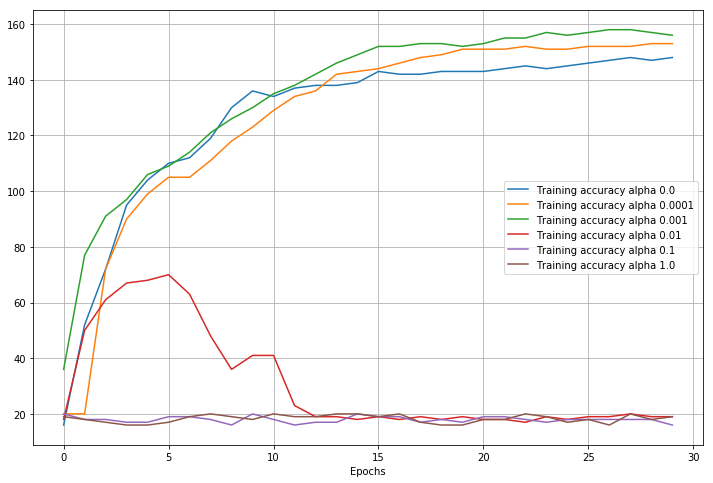

In [78]:
plt.figure(figsize=(12, 8))
for i, e_accuracy in enumerate(e_accuracies):
    # print(e_accuracy)
    plt.plot(e_accuracy, label="Training accuracy alpha {}".format(alphas[i]))
plt.grid(True)
plt.xlabel("Epochs")
plt.legend(loc='best')

## Dropout

Implement dropout as explained in 7.12. Create a function generateMask(p_input, p_hidden) that generates a list of l arrays, each element in l being an array of size (layer_size, 1). Each element of the array on the first level is 1 with probability p_input. Each element of the array on the last level (output layer) is 1. Each element of the other arrays is 1 with probability p_hidden. For this you can use the distribution scipy.stats.bernoulli. Add hyperparameters p_input and p_hidden to the network. 

Inference occurs as presented in equation 7.52. Plot how the test performance varies for various values of k. 

In [19]:
layers = [num_features, 50, 50, 50, num_classes]
net = Network(layers, p_DropOut = [0.8, 0.5])   # input / hidden unit
t_cost, t_accuracy, e_cost, e_accuracy = net.SGD(train_set, 3, 50, 0.1, validation_data=test_set,
                monitor_evaluation_cost=True,
                monitor_evaluation_accuracy=True,
                monitor_training_cost=True,
                monitor_training_accuracy=True)   # orig epochs 300

Epoch 0 complete
Cost on training data: 0.8757960137769899
Accuracy on training data: 143 / 1438
Cost on evaluation data: 0.875325027396041
Accuracy on evaluation data: 18 / 179
weights before rescale [[  9.32191312e-09   1.28001473e-08   3.55737804e-09 ...,   2.25109841e-09
    2.85208574e-09   0.00000000e+00]
 [  0.00000000e+00   7.04128250e-09   0.00000000e+00 ...,   3.01838212e-09
    0.00000000e+00   1.17456913e-08]
 [  0.00000000e+00   2.03068021e-08   0.00000000e+00 ...,   8.92175064e-10
    8.04434637e-09   2.71306177e-09]
 ..., 
 [  1.58086721e-08   8.23392299e-09   0.00000000e+00 ...,   2.14725295e-09
    0.00000000e+00   0.00000000e+00]
 [  9.21505653e-09   1.02417709e-08   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   1.81381260e-09]
 [  3.21648479e-09   4.07892787e-09   5.19038013e-09 ...,   4.36887197e-10
    1.61582845e-09   0.00000000e+00]] 



ValueError: too many values to unpack (expected 2)

## Early stopping

Implement early stopping as presented in algorithm 7.1 and 7.2. Make sure to make proper use of the validation and the test set (as provided above). 

Demonstrate the correct usage by plotting learning curves for train, validation and test performance. 